In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import lightgbm as lgb
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)
tf.random.set_seed(42)


def load_and_preprocess_data(file_path):
    """Load and preprocess the energy data."""
    # Load the data
    df = pd.read_excel(file_path)

    # Convert datetime to pandas datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Set datetime as index
    df.set_index('datetime', inplace=True)

    # Add time-based features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek >= 5


    # Calculate total renewable generation
    df['renewable_gen'] = df['PV (kWh)'] + df['Wind_Power (kWh)']

    # Calculate net load (load - renewable generation)
    df['grid_demand'] = (df['Load (kWh)'] - df['renewable_gen']).clip(lower=0)

    df= df.drop('Unmet(kWh)', axis=1) #Drop unnecessary columns


    return df

df=load_and_preprocess_data("/content/energy_data_update (1).xlsx")


In [33]:
Hour_List=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

In [3]:

df.head()

,temp,feelslike,humidity,precip,windspeed,sealevelpressure,cloudcover,visibility,purchasing price (dollar/kWh),Load (kWh),...,No. 2 Heating Oil ($/Gallon),No. 2 Diesel Fuel (($/Gallon)),Wind_Power (kWh),hour,day,month,dayofweek,is_weekend,renewable_gen,grid_demand
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,-4.0,-11.3,49.86,0.0,26.7,1024.9,41.6,16.0,0.3168,2698,...,3.04,3.087,24.450314,0,1,1,6,True,24.450314,2673.549686
2012-01-01 01:00:00,-4.1,-11.2,50.05,0.0,25.5,1025.5,97.9,16.0,0.2988,2558,...,3.04,3.087,21.320055,1,1,1,6,True,21.320055,2536.679945
2012-01-01 02:00:00,-3.2,-11.1,46.07,0.0,34.2,1026.0,100.0,16.0,0.2701,2444,...,3.04,3.087,51.287699,2,1,1,6,True,51.287699,2392.712301
2012-01-01 03:00:00,-3.1,-11.5,46.33,0.0,40.0,1026.8,100.0,16.0,0.2606,2402,...,3.04,3.087,82.089595,3,1,1,6,True,82.089595,2319.910405
2012-01-01 04:00:00,-4.1,-12.6,50.07,0.0,37.8,1027.9,19.5,16.0,0.2564,2403,...,3.04,3.087,69.607988,4,1,1,6,True,69.607988,2333.392012


In [4]:

# plt.figure(figsize=(50, 15))
# plt.plot(df['purchasing price (dollar/kWh)'])
# plt.plot(df['generation_price'])
# # plt.plot(df['temp']/300)
# # plt.plot(df['feelslike']/300)
# plt.show()


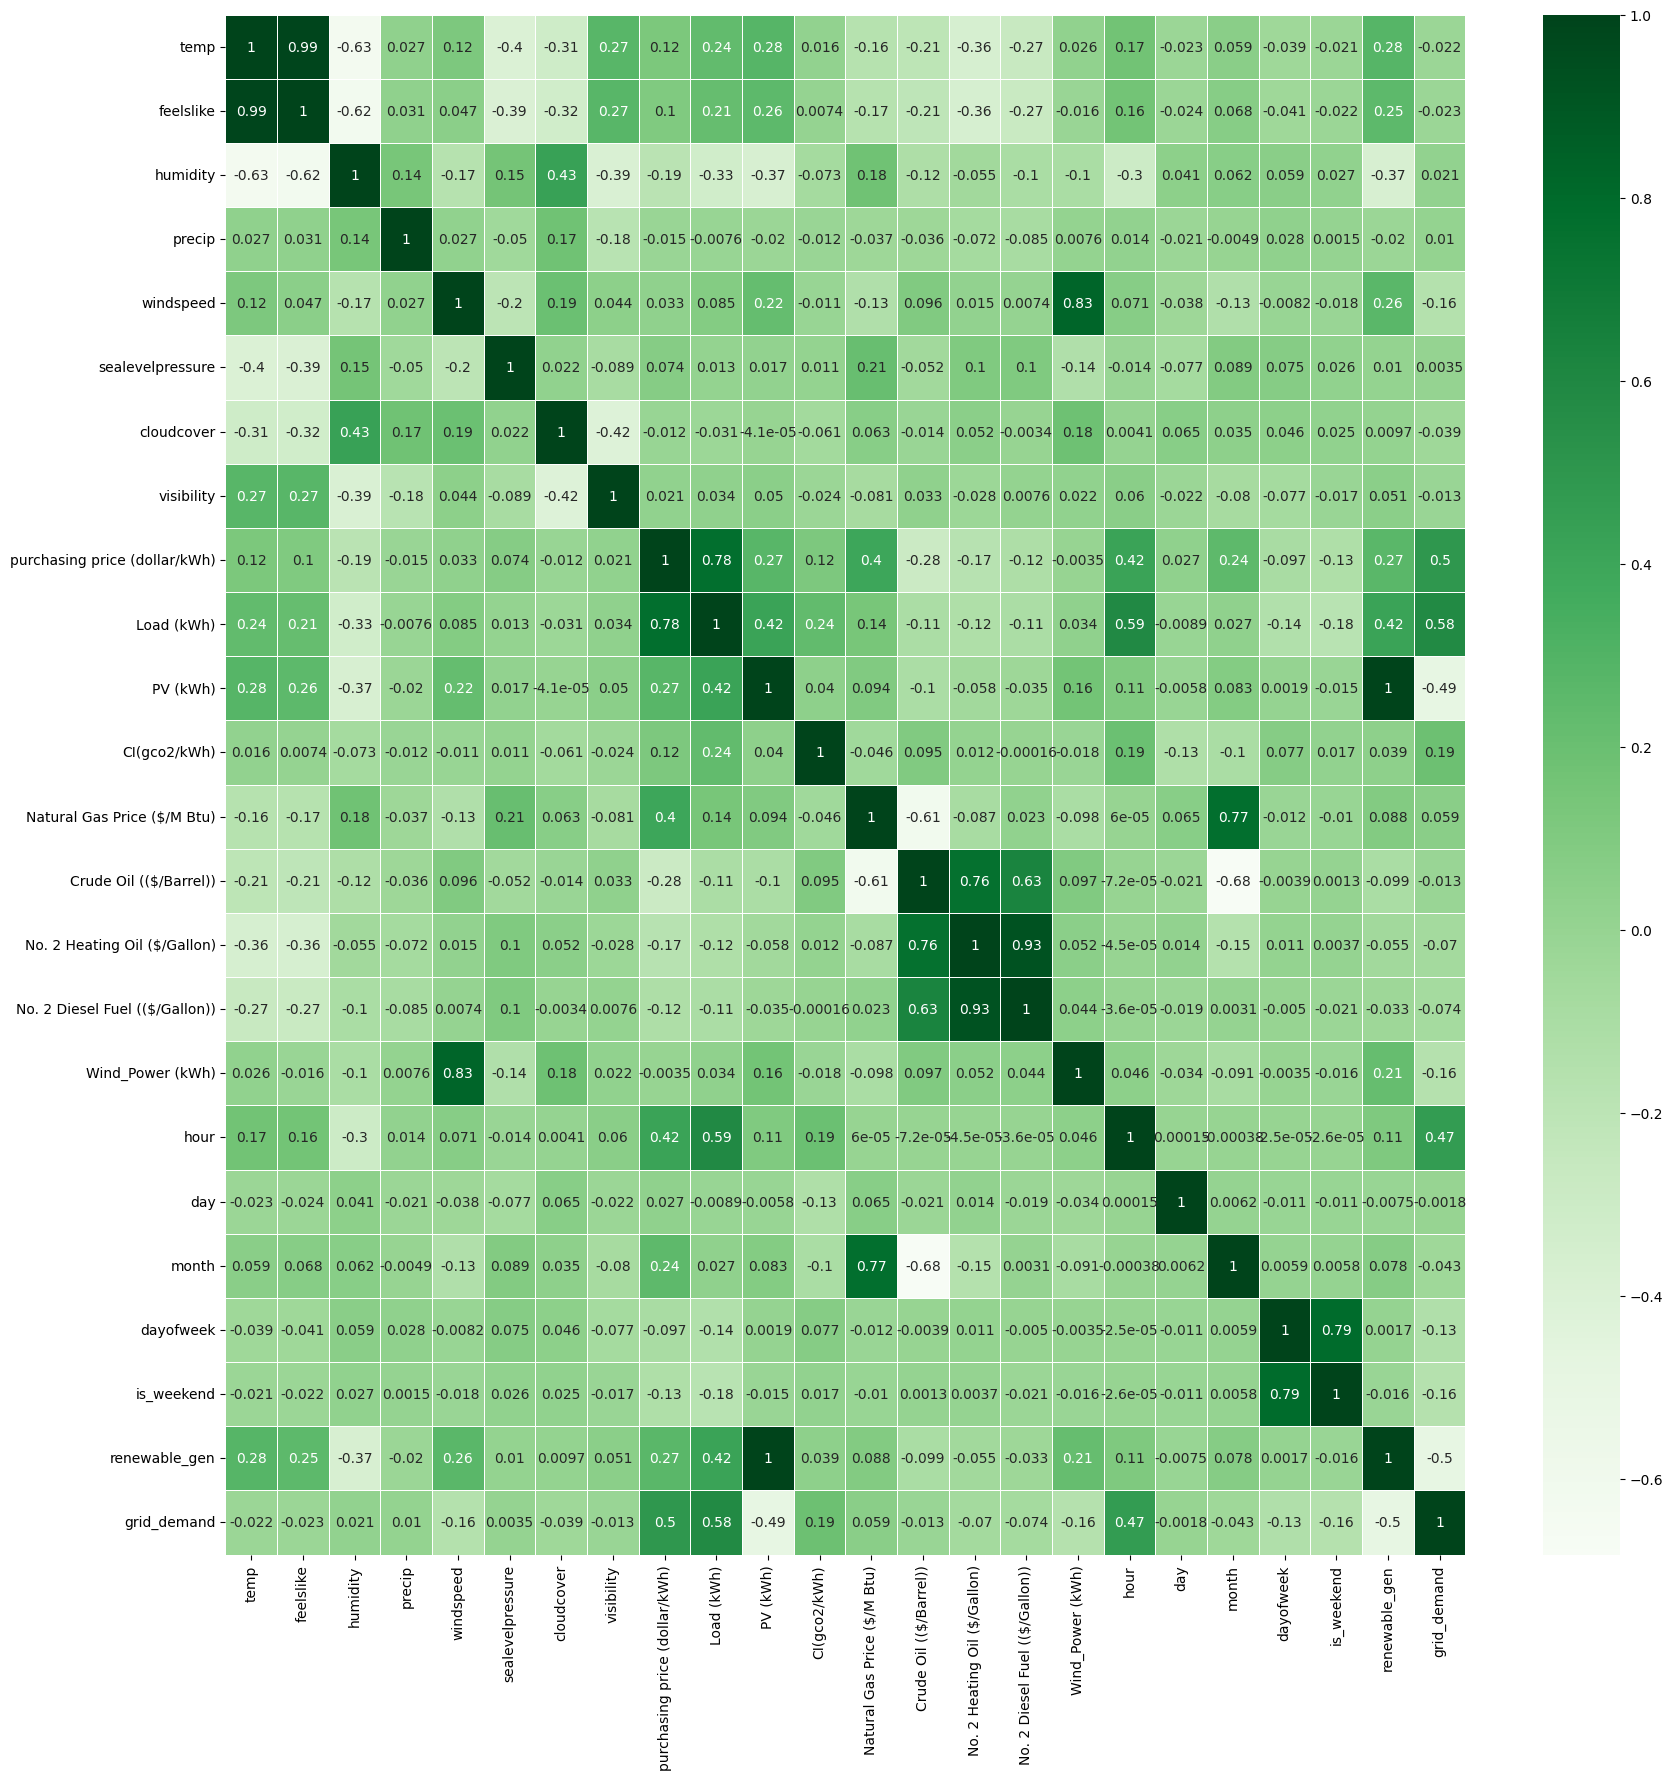

In [5]:
import seaborn as sns
matrix = df.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(matrix, cmap="Greens", annot=True, linewidths=.5, ax=ax)
plt.show()

In [6]:
columns=(list(df.columns))
print(columns)

['temp', 'feelslike', 'humidity', 'precip', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'purchasing price (dollar/kWh)', 'Load (kWh)', 'PV (kWh)', 'CI(gco2/kWh)', 'Natural Gas Price ($/M Btu)', 'Crude Oil (($/Barrel))', 'No. 2 Heating Oil ($/Gallon)', 'No. 2 Diesel Fuel (($/Gallon))', 'Wind_Power (kWh)', 'hour', 'day', 'month', 'dayofweek', 'is_weekend', 'renewable_gen', 'grid_demand']


In [7]:
load_demand_X = df[['temp', 'feelslike', 'humidity', 'hour', 'dayofweek', 'is_weekend','month', 'CI(gco2/kWh)']]
pv_gen_X   = df[['temp', 'feelslike', 'humidity','precip','visibility', 'windspeed','hour','cloudcover','month','is_weekend','day','CI(gco2/kWh)']]
wind_gen_X = df[['windspeed', 'sealevelpressure', 'cloudcover', 'month','hour']]
load_demand_y=df['Load (kWh)']
pv_gen_y=df['PV (kWh)']
wind_gen_y=df['Wind_Power (kWh)']

In [8]:
print(load_demand_X.shape)
print(load_demand_y.shape)
print(pv_gen_X.shape)
print(pv_gen_y.shape)
print(wind_gen_X.shape)
print(wind_gen_y.shape)

(8784, 8)
(8784,)
(8784, 12)
(8784,)
(8784, 5)
(8784,)


In [9]:
def train_demand_model(X, y):
    """Train a machine learning model for demand prediction."""
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("The columns of X_train are : ",X_train.columns)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

        # Train Random Forest model
    model = RandomForestRegressor(n_estimators=400, random_state=42)

    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("The value of rmse for demand",rmse)
    print("The value of r2 for demand is",r2)

    return model, scaler

demand_model,demand_scaler=train_demand_model(load_demand_X,load_demand_y)



The columns of X_train are :  Index(['temp', 'feelslike', 'humidity', 'hour', 'dayofweek', 'is_weekend',
       'month', 'CI(gco2/kWh)'],
      dtype='object')
The value of rmse for demand 144.93608480740969
The value of r2 for demand is 0.9357468021027421


In [10]:
# def train_renewable_model(X, y, renewable_type):
def train_PV(X, y):
    """Train a machine learning model for renewable energy prediction."""
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("The value of rmse for PV",rmse)
    print("The value of r2 for PV is",r2)

    return model, scaler


pv_model, pv_scaler=train_PV(pv_gen_X,pv_gen_y)

The value of rmse for PV 180.88244545741833
The value of r2 for PV is 0.8777388885004418


In [11]:
# def train_renewable_model(X, y, renewable_type):
def train_Wind(X, y):
    """Train a machine learning model for renewable energy prediction."""
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("The value of rmse for renewable",rmse)
    print("The value of r2 for renewable is",r2)

    return model, scaler
wind_model, wind_scaler=train_Wind(wind_gen_X,wind_gen_y)

The value of rmse for renewable 0.8510215419266388
The value of r2 for renewable is 0.9989583373059366


In [12]:
def predict_price(df):
    y=df['purchasing price (dollar/kWh)']
    X=df[["Load (kWh)",'PV (kWh)','Wind_Power (kWh)','hour','month','is_weekend','Natural Gas Price ($/M Btu)','Crude Oil (($/Barrel))']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1,
                                       max_depth=6, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("The value of rmse for price",rmse)
    print("The value of r2 for price is",r2)

    return model, scaler
price_model, price_scaler=predict_price(df)


The value of rmse for price 0.033597365734349904
The value of r2 for price is 0.9552334861969762


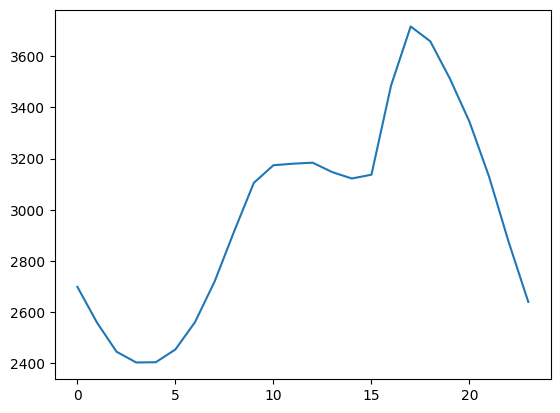

In [13]:
price=[]
load=[]
grid=[]
price=[]
for i in range(24):
  price.append(df['purchasing price (dollar/kWh)'][i])
  load.append(df['Load (kWh)'][i])
  grid.append(df['grid_demand'][i])

plt.plot(load)

# plt.plot(price,grid)

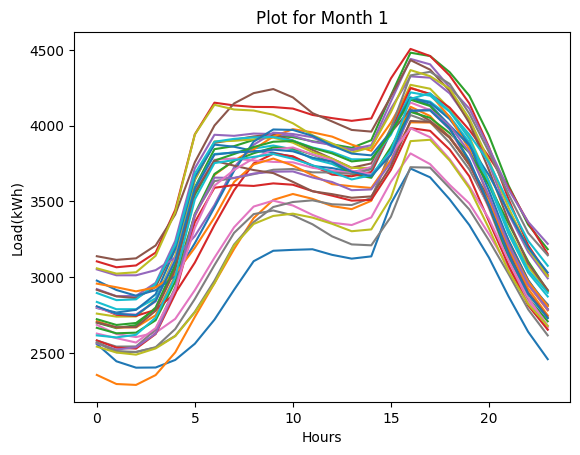

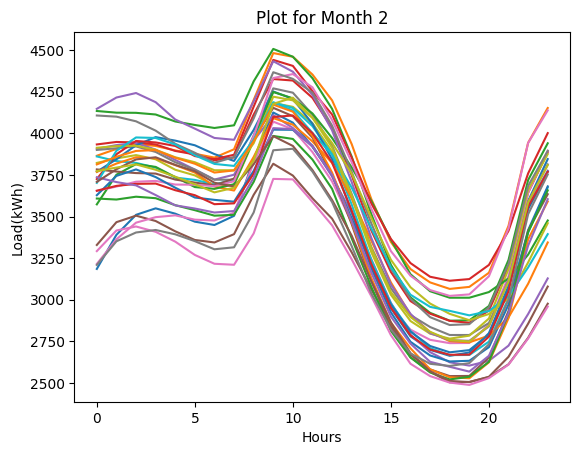

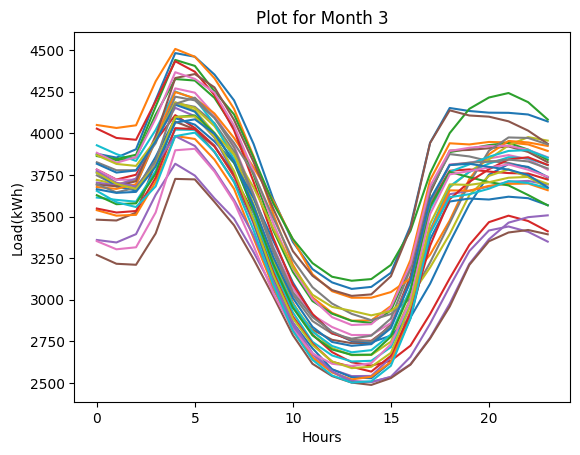

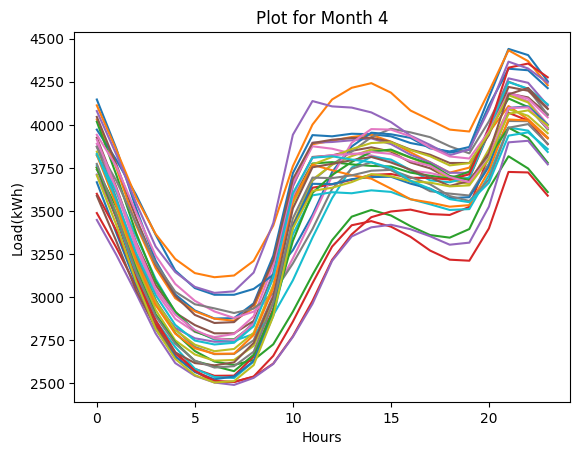

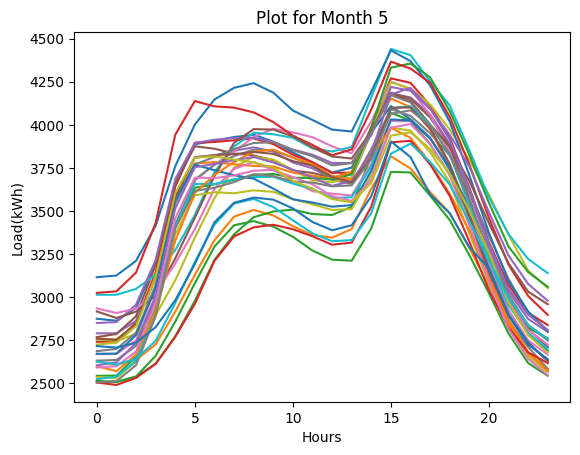

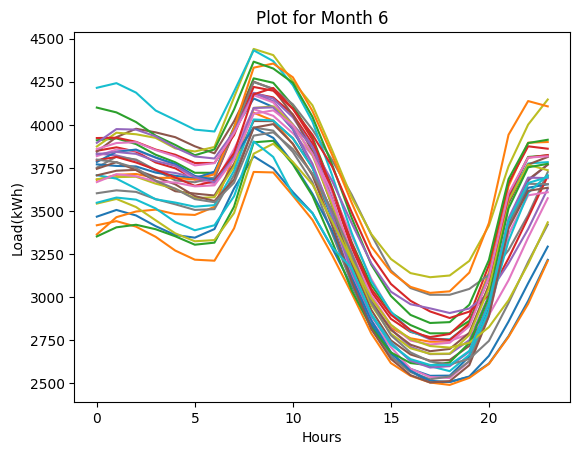

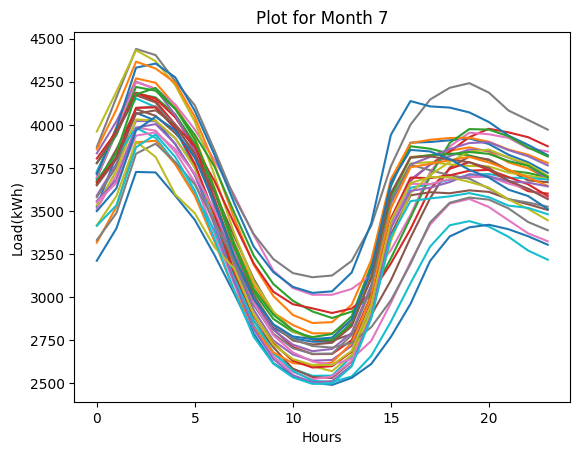

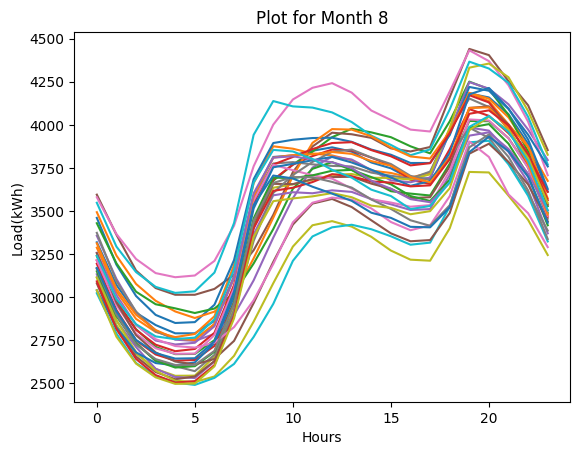

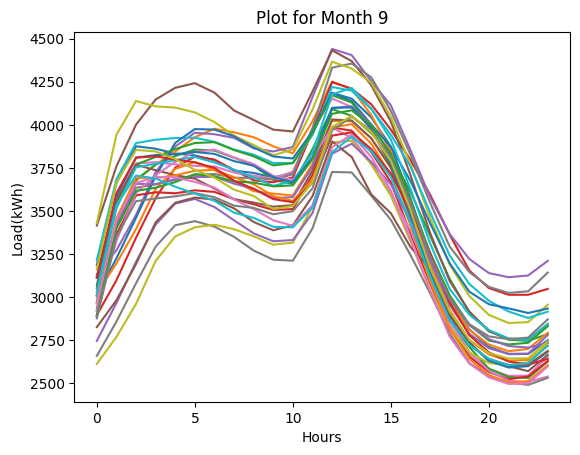

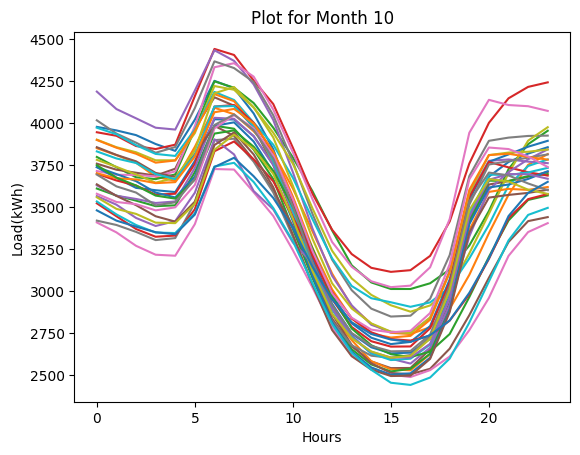

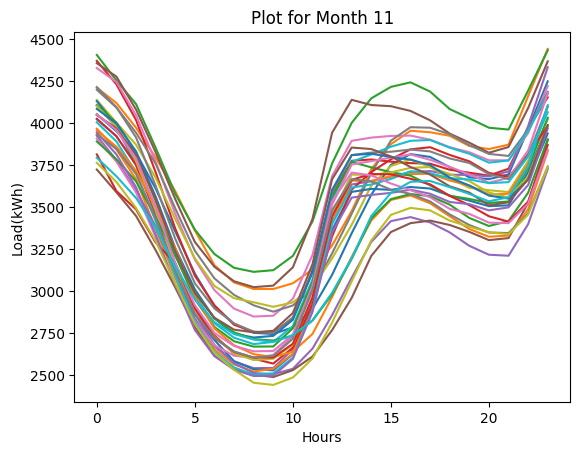

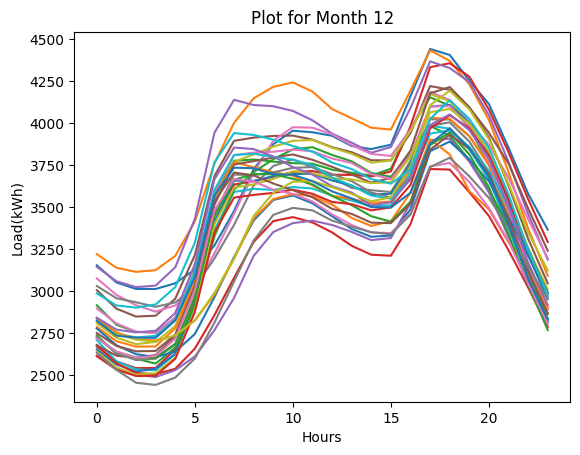

In [14]:
# df= pd.read_excel("/content/energy_data_update (1).xlsx", index_col=0)
months=[31, 29, 31,30,31,30,31,31,30,31,30,31]
def Load_Curve(i):
     month_days=months[i]
     start= sum(months[:i])

     plt.title(f"Plot for Month {i+1}")
     x= np.arange(24)
     for j in range(month_days):
        y= df["Load (kWh)"][start+1+(24*j):(start+1)+24*(j+1)].to_numpy()
        plt.xlabel("Hours")
        plt.ylabel("Load(kWh)")
        plt.plot(x,y)
     plt.show()

for i in range(12):
    Load_Curve(i)



[0.3168  0.26892 0.24309 0.23454 0.23076 0.24561 0.2853  0.3116  0.3218
 0.3556  0.3594  0.3568  0.3443  0.3317  0.3158  0.3007  0.58308 0.8928
 0.76752 0.73512 0.69048 0.5399  0.3124  0.3151 ]


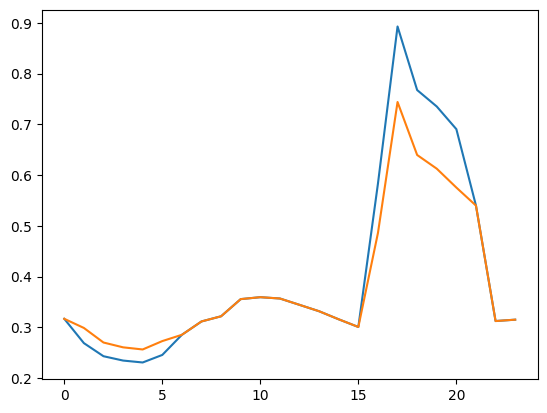

In [15]:
def prices_func(prices, num_peak_hours=5, num_offpeak_hours=5):
   base_prices = np.array(prices, dtype=np.float64)
   dynamic_prices = base_prices.copy()
   load_sorted_indices = np.argsort(load)

   offpeak_hours = load_sorted_indices[:num_offpeak_hours]
   peak_hours = load_sorted_indices[-num_peak_hours:]
   for i in range(24):
        if i in peak_hours:
            dynamic_prices[i] *= 1.2
        elif i in offpeak_hours:
            dynamic_prices[i] *= 0.90
   dynamic_prices = np.clip(dynamic_prices, 0.1, 10.0)

   return dynamic_prices

print(prices_func(price))
plt.plot(prices_func(price))
plt.plot(price)

In [16]:
def pso_final(predicted_load, prices, max_iterations=1000, num_particles=3000):
    """
    Particle Swarm Optimization for load shifting under TOU pricing.
    """
    predicted_load = np.array(predicted_load)
    prices = np.array(prices)

    # Problem dimensions
    dimensions = len(predicted_load)
    total_daily_load = np.sum(predicted_load)
    max_shift_per_hour = 0.15 * predicted_load  # Max 15% shift up or down

    # Particle Initialization
    particles = np.zeros((num_particles, dimensions))
    for i in range(num_particles):
        # Randomly perturb each hour within +/-20%
        perturbation = np.random.uniform(-0.2, 0.2, size=dimensions)
        shifted = predicted_load * (1 + perturbation)
        shifted = np.clip(shifted, predicted_load - max_shift_per_hour, predicted_load + max_shift_per_hour)
        # Normalize to preserve total energy
        shifted *= total_daily_load / np.sum(shifted)
        particles[i] = shifted

    velocities = np.random.uniform(-0.1, 0.1, size=(num_particles, dimensions))  # Small random initial velocities

    # Bests
    personal_best_positions = particles.copy()
    personal_best_costs = np.array([calculate_cost(p, prices) for p in particles])

    global_best_idx = np.argmin(personal_best_costs)
    global_best_position = personal_best_positions[global_best_idx].copy()
    global_best_cost = personal_best_costs[global_best_idx]

    # PSO parameters
    w_max, w_min = 0.9, 0.4  # Inertia weight decays
    c1 = 2.0  # Cognitive (personal best) coefficient
    c2 = 2.0  # Social (global best) coefficient
    v_max = 0.2 * predicted_load  # Max velocity per hour

    for iteration in range(max_iterations):
        w = w_max - (w_max - w_min) * (iteration / max_iterations)  # Inertia decay

        for i in range(num_particles):
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)

            # Velocity update
            velocities[i] = (
                w * velocities[i] +
                c1 * r1 * (personal_best_positions[i] - particles[i]) +
                c2 * r2 * (global_best_position - particles[i])
            )

            # Clamp velocities
            velocities[i] = np.clip(velocities[i], -v_max, v_max)

            # Position update
            particles[i] += velocities[i]

            # Enforce constraints
            particles[i] = np.clip(particles[i], predicted_load - max_shift_per_hour, predicted_load + max_shift_per_hour)
            particles[i] = np.clip(particles[i], 0, None)  # No negative loads
            particles[i] *= total_daily_load / np.sum(particles[i])  # Re-normalize to preserve energy

            # Cost evaluation
            cost = calculate_cost(particles[i], prices)

            # Personal best update
            if cost < personal_best_costs[i]:
                personal_best_positions[i] = particles[i].copy()
                personal_best_costs[i] = cost

                # Global best update
                if cost < global_best_cost:
                    global_best_position = particles[i].copy()
                    global_best_cost = cost

    return global_best_position


def calculate_cost(load_profile, prices):
    """Calculate total cost of a load profile."""
    return np.sum(load_profile * prices)


In [44]:
final_prices= prices_func(price)
pso_final_result=pso_final(load,final_prices)
print(pso_final_result)

[2920.48969257 2768.9446381  2645.54366517 2600.08014883 2601.16261351
 2655.28584725 2771.10956745 2943.22145074 3156.46699167 3361.05281521
 3435.74287777 3442.23766582 3446.56752451 3406.51633155 3379.45471468
 3395.6916848  2789.08789379 2973.90697109 2927.50218111 2810.6901236
 2675.47616662 2503.45841069 3095.68574673 2856.62427676]
The maximum percentage reduction in load is:  0.07275557586368615


In [46]:
max_load=max(load)
max_pso_final=max(pso_final_result)
print("The maximum percentage reduction in load is: ",(max_load-max_pso_final)*100/max_load)

The maximum percentage reduction in load is:  7.275557586368616


In [18]:
def predict_next_day1(df,demand_model,demand_scaler,pv_model, pv_scaler,wind_model, wind_scaler,price_model, price_scaler):
  load_X = df[['temp', 'feelslike', 'humidity', 'hour', 'dayofweek', 'is_weekend','month', 'CI(gco2/kWh)']].iloc[-24:]
  pv_X   = df[['temp', 'feelslike', 'humidity','precip','visibility', 'windspeed','hour','cloudcover','month','is_weekend','day','CI(gco2/kWh)']].iloc[-24:]
  wind_X = df[['windspeed', 'sealevelpressure', 'cloudcover', 'month','hour']].iloc[-24:]
  price_X=df[["Load (kWh)",'PV (kWh)','Wind_Power (kWh)','hour','month','is_weekend','Natural Gas Price ($/M Btu)','Crude Oil (($/Barrel))']].iloc[-24:]
  load_X_scaled=demand_scaler.transform(load_X)
  pv_X_scaled=pv_scaler.transform(pv_X)
  wind_X_scaled=wind_scaler.transform(wind_X)
  price_X_scaled=price_scaler.transform(price_X)

  load_pred=demand_model.predict(load_X_scaled)
  pv_pred=pv_model.predict(pv_X_scaled)
  wind_pred=wind_model.predict(wind_X_scaled)
  price_pred=price_model.predict(price_X_scaled)

  return load_pred,pv_pred,wind_pred,price_pred

Predicted_Load,Predicted_PV,Predicted_Wind,Predicted_Price=predict_next_day1(df,demand_model,demand_scaler,pv_model, pv_scaler,wind_model, wind_scaler,price_model, price_scaler)

In [19]:
print(np.sum(load))
print(np.sum(pso_final_result))

71562.0
71562.00000000001


In [20]:
def cal_change(load1,load2):
  val=0
  for i in range(24):
    x=(load1[i]-load2[i])
    if x>=0:
     val+=x
  return val

In [21]:
def cal_price(load,price):
  val=0
  for i in range(24):
    val+=load[i]*price[i]
  return val

In [22]:
initial_price=cal_price(load,price)
pso_price= cal_price(pso_final_result, price )
print("Initial Price: ", initial_price)
print("Final price: ",pso_price)

Initial Price:  28449.7191
Final price:  27242.22628478181


In [23]:
total_load=np.sum(load)
change=cal_change(load,pso_final_result)
print(change)
print("Percentage change: ",(change*100)/total_load)

4171.195638194204
Percentage change:  5.828785721743667


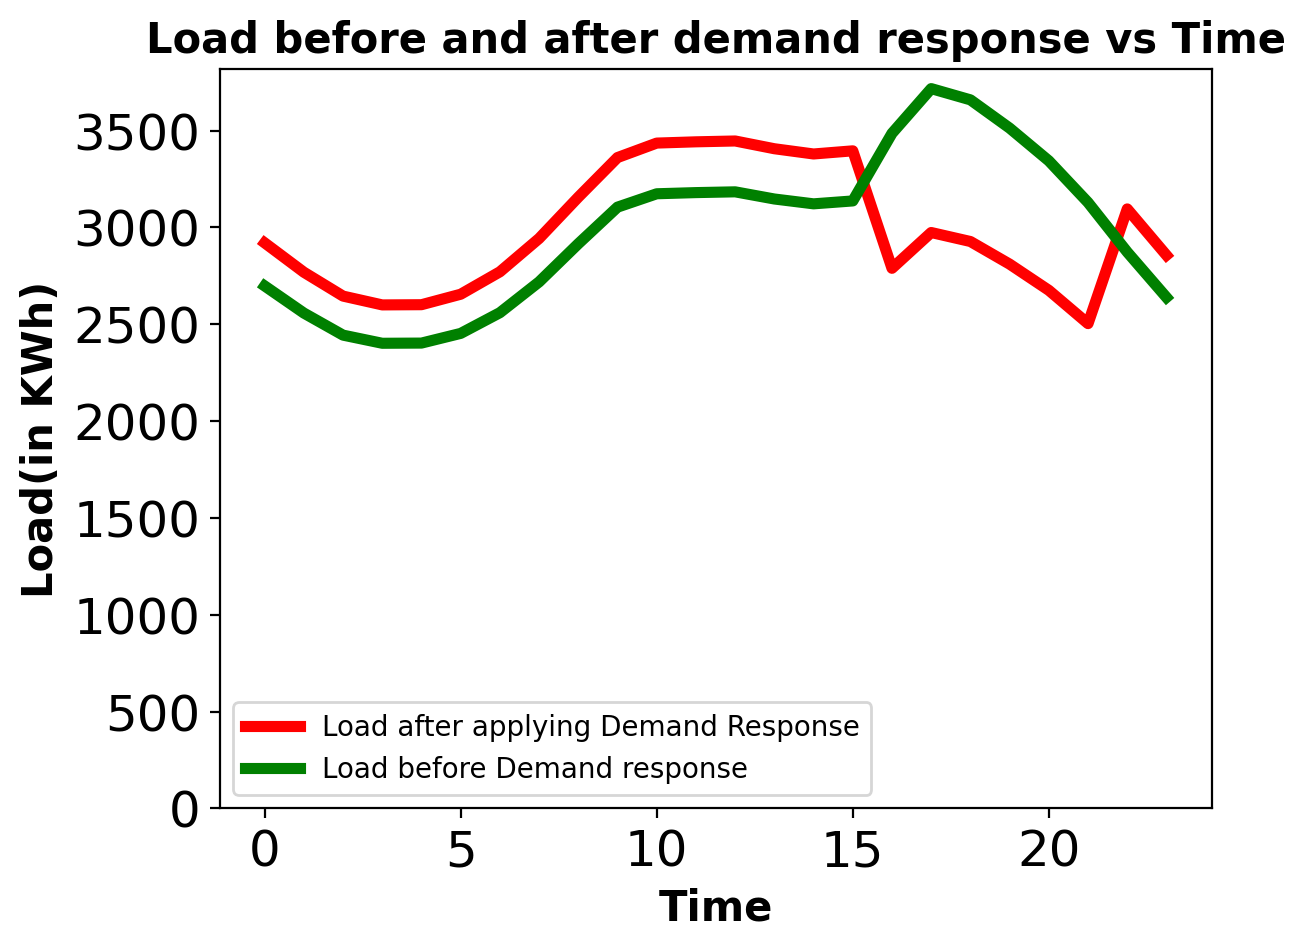

In [45]:
# Plotting both the curves simultaneously
plt.figure(dpi=200)
plt.plot( Hour_List, pso_final_result,color='r', label='Load after applying Demand Response',linewidth=4)
plt.plot( Hour_List,load, color='g', label='Load before Demand response',linewidth=4)

plt.ylim(0, max(load)+100)
# Naming the x-axis, y-axis and the whole graph
plt.xticks(fontsize=18, fontweight='normal')
plt.yticks(fontsize=18, fontweight='normal')
plt.ylabel("Load(in KWh)",fontsize=15, fontweight='bold')
plt.xlabel("Time",fontsize=15, fontweight='bold')
plt.title("Load before and after demand response vs Time",fontsize=15, fontweight='bold')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [26]:
print(columns)

['temp', 'feelslike', 'humidity', 'precip', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'purchasing price (dollar/kWh)', 'Load (kWh)', 'PV (kWh)', 'CI(gco2/kWh)', 'Natural Gas Price ($/M Btu)', 'Crude Oil (($/Barrel))', 'No. 2 Heating Oil ($/Gallon)', 'No. 2 Diesel Fuel (($/Gallon))', 'Wind_Power (kWh)', 'hour', 'day', 'month', 'dayofweek', 'is_weekend', 'renewable_gen', 'grid_demand']


In [27]:
# Extract the last 24 values
Original_Load = df['Load (kWh)'].iloc[-24:].tolist()
Original_Wind = df['Wind_Power (kWh)'].iloc[-24:].tolist()
Original_PV = df['PV (kWh)'].iloc[-24:].tolist()
Original_Price = df['purchasing price (dollar/kWh)'].iloc[-24:].tolist()

# # Extract the first 24 values (top 24 rows)
# Original_Load = df['Load (kWh)'].iloc[:24].tolist()
# Original_Wind = df['Wind_Power (kWh)'].iloc[:24].tolist()
# Original_PV = df['PV (kWh)'].iloc[:24].tolist()
# Original_Price = df['purchasing price (dollar/kWh)'].iloc[:24].tolist()


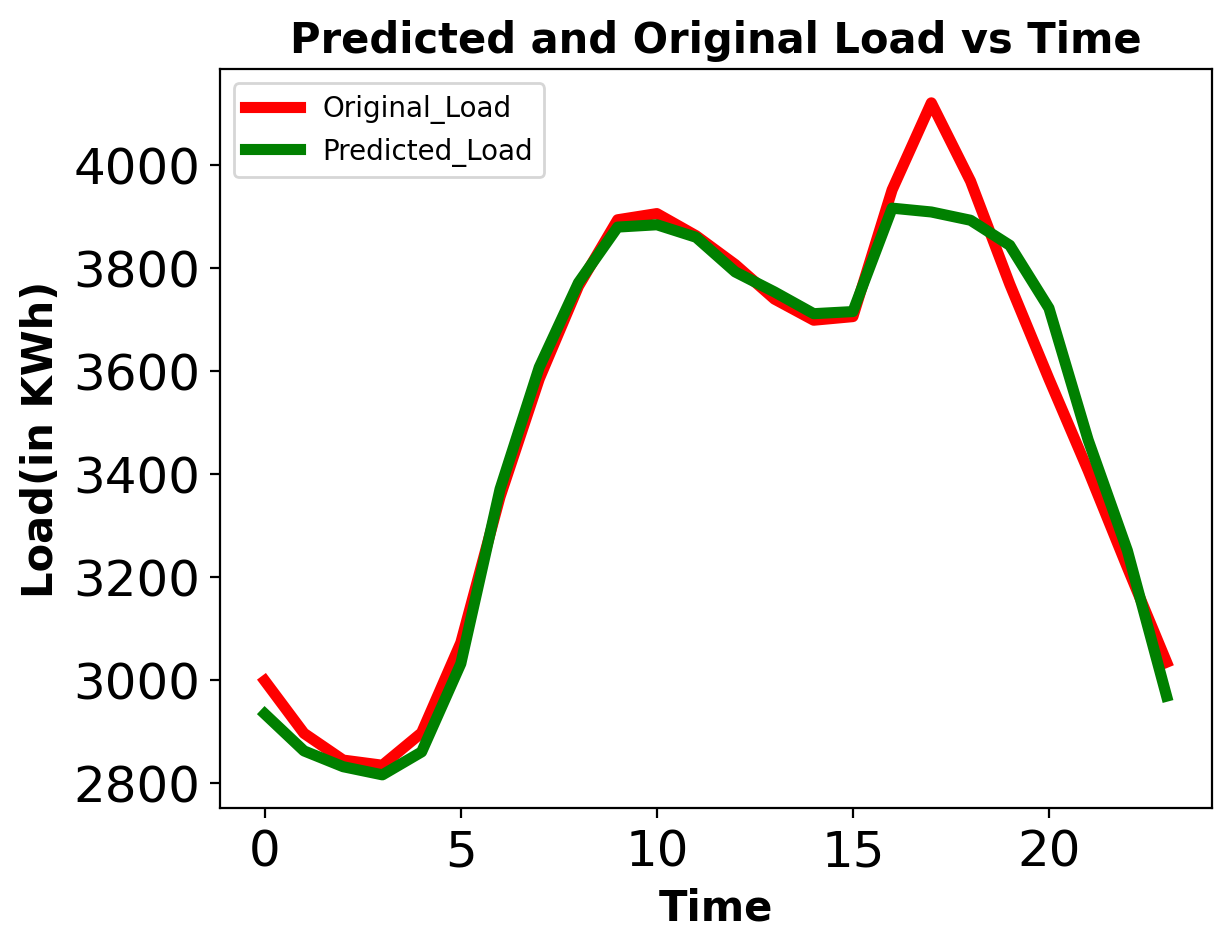

In [47]:
#Important next day plots:
# Plotting both the curves simultaneously
plt.figure(dpi=200)
plt.plot( Hour_List, Original_Load,color='r', label='Original_Load',linewidth=4)
plt.plot( Hour_List,Predicted_Load, color='g', label='Predicted_Load',linewidth=4)

plt.xticks(fontsize=18, fontweight='normal')
plt.yticks(fontsize=18, fontweight='normal')
plt.ylabel("Load(in KWh)",fontsize=15, fontweight='bold')
plt.xlabel("Time",fontsize=15, fontweight='bold')
plt.title("Predicted and Original Load vs Time",fontsize=15, fontweight='bold')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

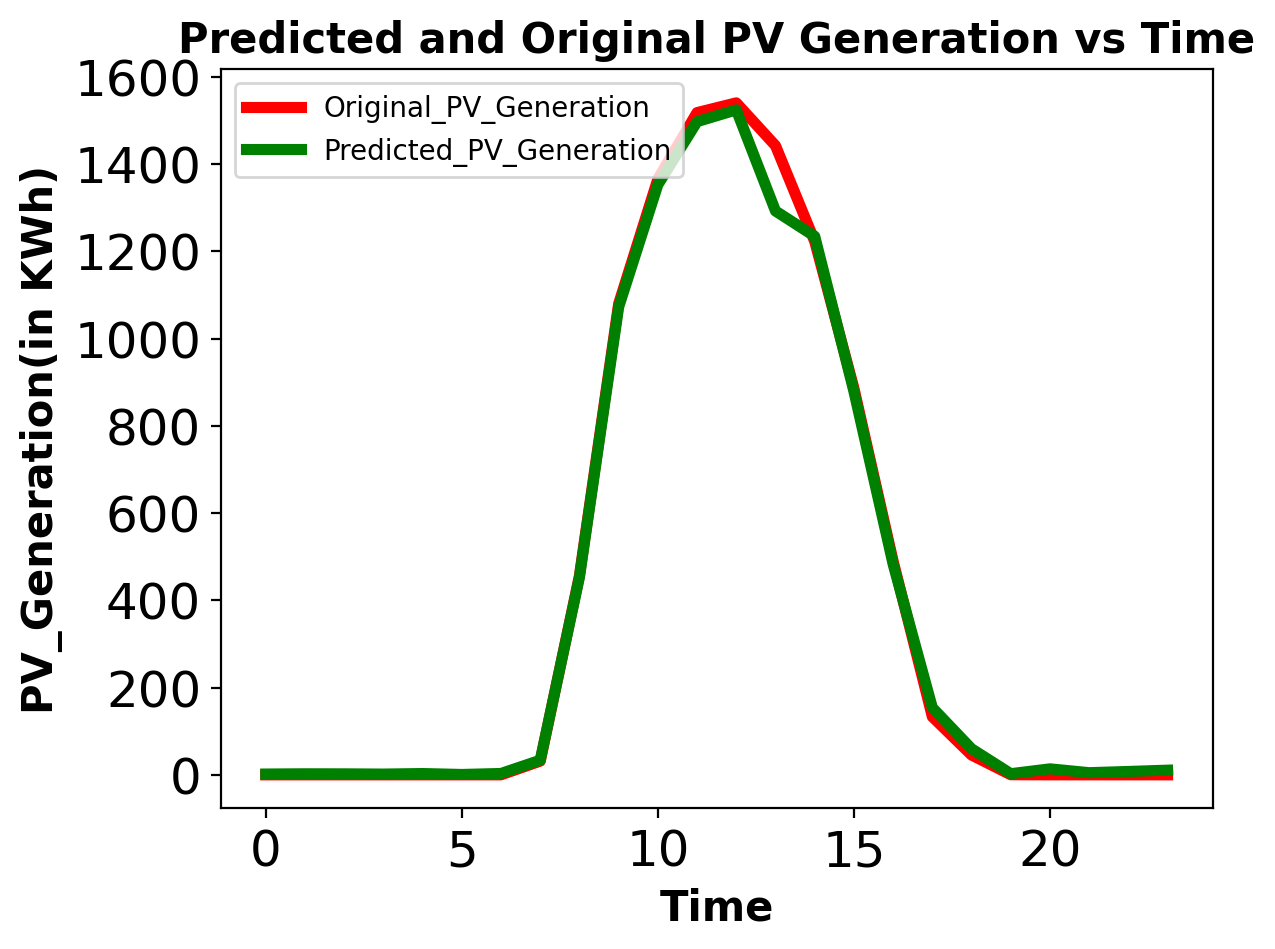

In [49]:
# Plotting both the curves simultaneously
plt.figure(dpi=200)
plt.plot( Hour_List,Original_PV, color='r', label='Original_PV_Generation',linewidth=4)
plt.plot( Hour_List,Predicted_PV, color='g', label='Predicted_PV_Generation',linewidth=4)


plt.xticks(fontsize=18, fontweight='normal')
plt.yticks(fontsize=18, fontweight='normal')
plt.ylabel("PV_Generation(in KWh)",fontsize=15, fontweight='bold')
plt.xlabel("Time",fontsize=15, fontweight='bold')
plt.title("Predicted and Original PV Generation vs Time",fontsize=15, fontweight='bold')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

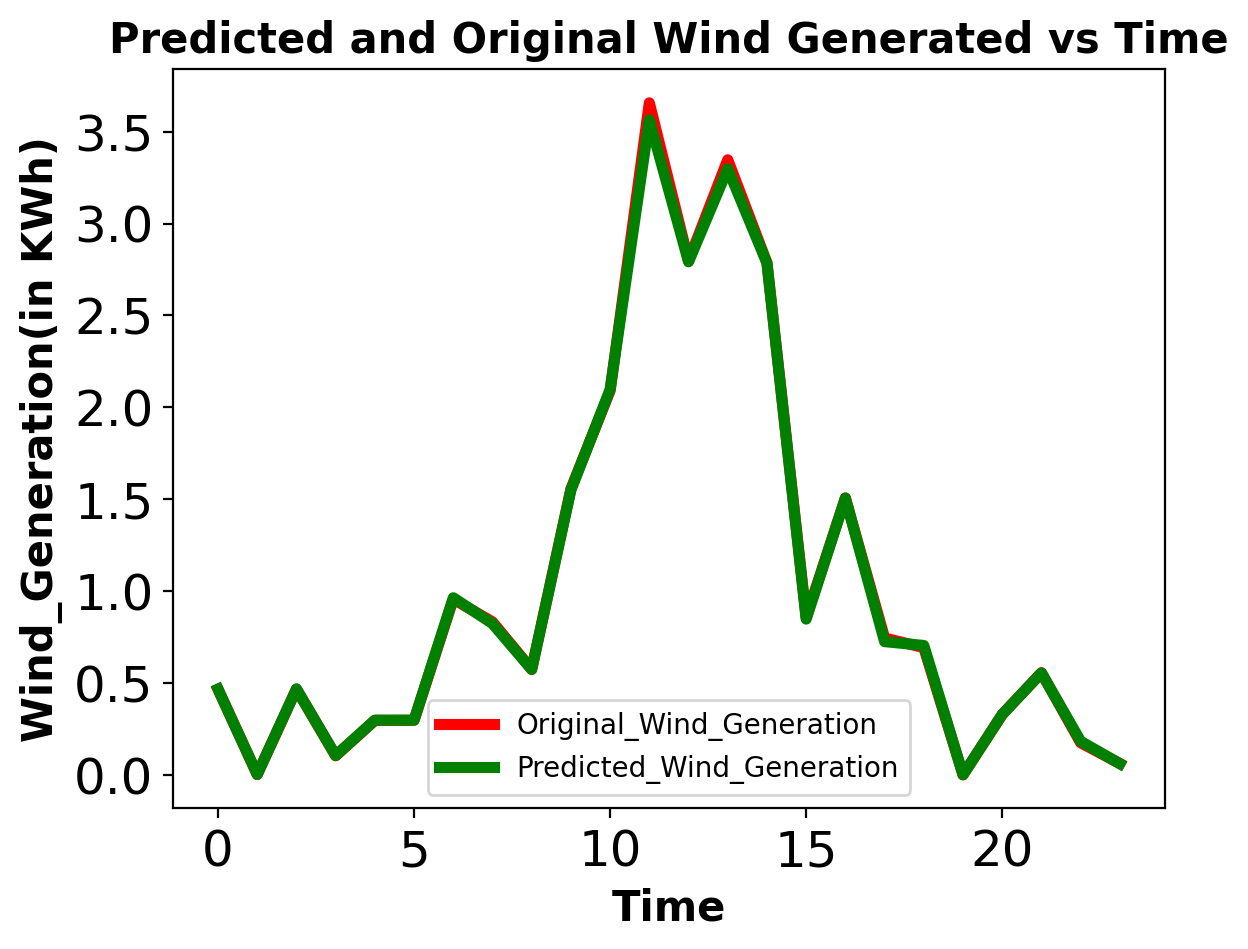

In [50]:
# Plotting both the curves simultaneously
plt.figure(dpi=200)
plt.plot( Hour_List,Original_Wind, color='r', label='Original_Wind_Generation',linewidth=4)
plt.plot( Hour_List,Predicted_Wind, color='g', label='Predicted_Wind_Generation',linewidth=4)

# Naming the x-axis, y-axis and the whole graph
plt.xticks(fontsize=18, fontweight='normal')
plt.yticks(fontsize=18, fontweight='normal')
plt.ylabel("Wind_Generation(in KWh)",fontsize=15, fontweight='bold')
plt.xlabel("Time",fontsize=15, fontweight='bold')
plt.title("Predicted and Original Wind Generated vs Time",fontsize=15, fontweight='bold')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

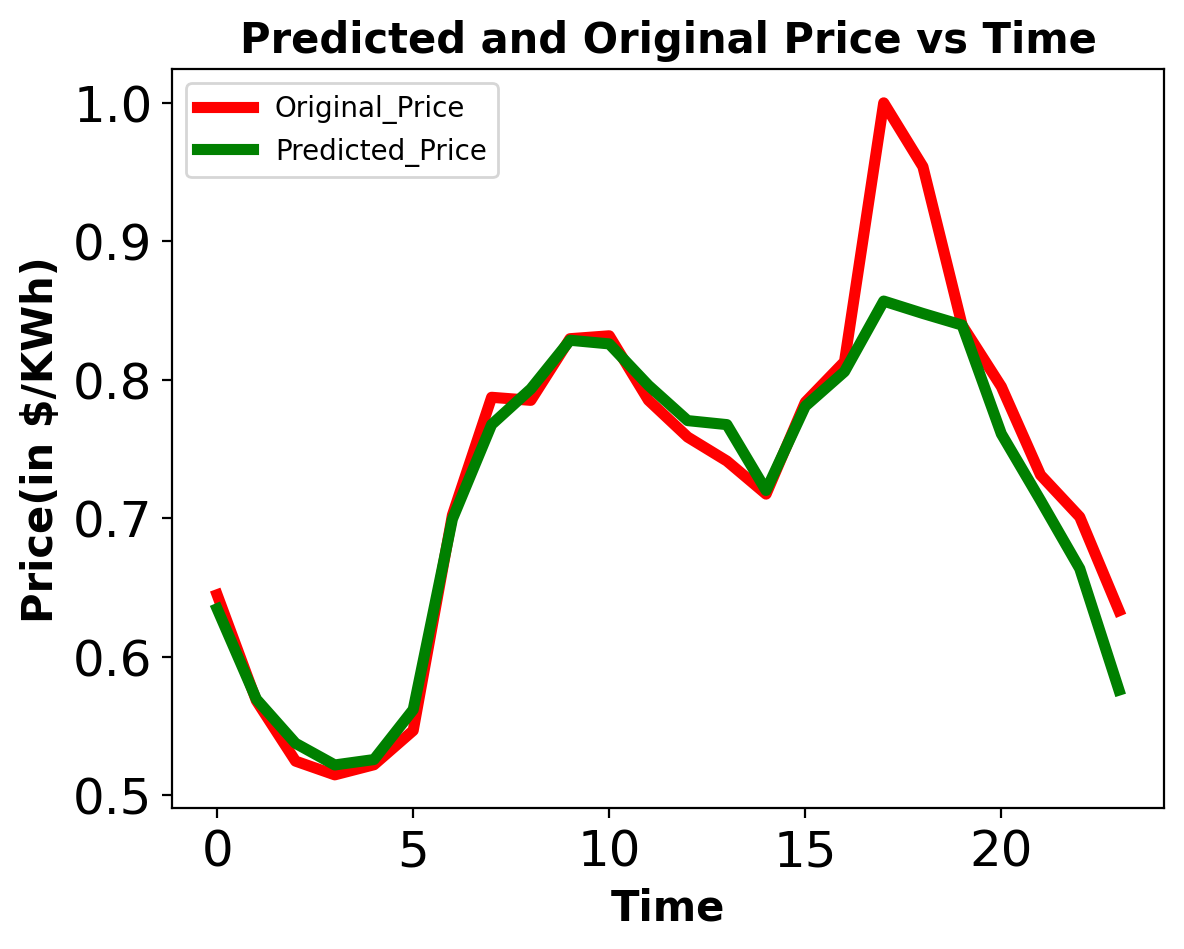

In [54]:
# Plotting both the curves simultaneously
plt.figure(dpi=200)
plt.plot( Hour_List,Original_Price, color='r', label='Original_Price',linewidth=4)
plt.plot( Hour_List,Predicted_Price, color='g', label='Predicted_Price',linewidth=4)

# Naming the x-axis, y-axis and the whole graph
plt.xticks(fontsize=18, fontweight='normal')
plt.yticks(fontsize=18, fontweight='normal')
plt.ylabel("Price(in $/KWh)",fontsize=15, fontweight='bold')
plt.xlabel("Time",fontsize=15, fontweight='bold')
plt.title("Predicted and Original Price vs Time",fontsize=15, fontweight='bold')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()